<a href="https://colab.research.google.com/github/ImolaFodor/probabilistic-ML/blob/main/HW04_PML_IF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip3 install pyro-ppl

     |████████████████████████████████| 718 kB 4.3 MB/s 


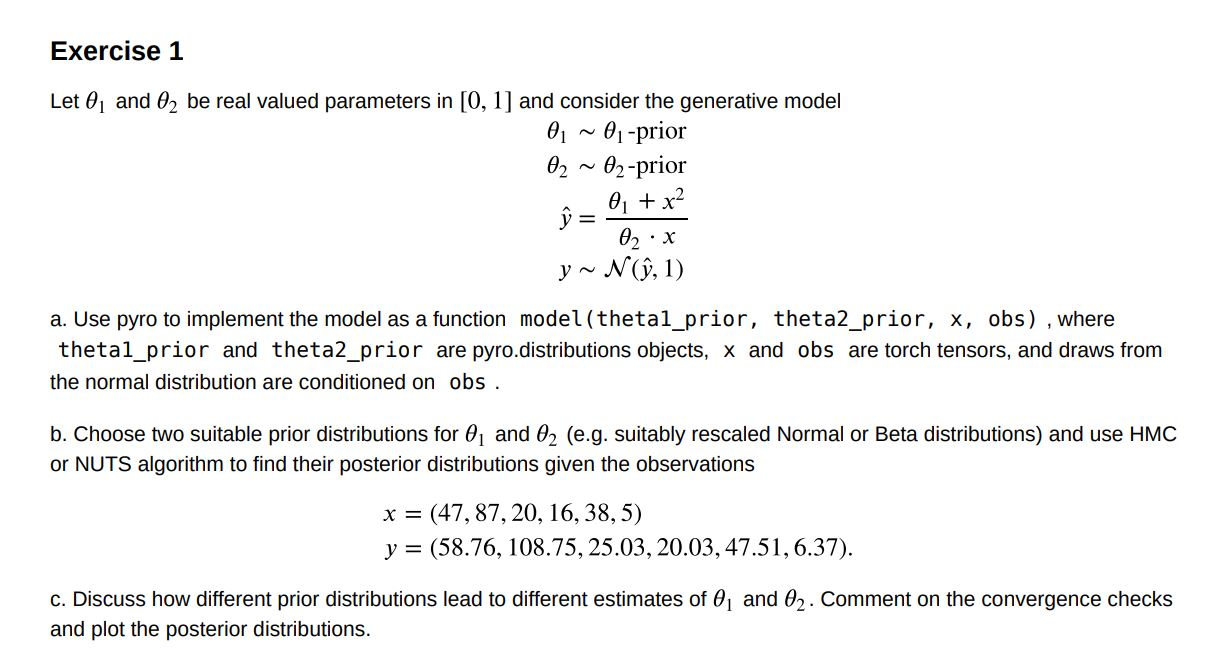

In [3]:
import torch
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import pyro
import pyro.distributions as dist
from pyro.infer.mcmc import MCMC, HMC, NUTS
pyro.set_rng_seed(0)

In [14]:
def model(theta1_prior, theta2_prior,x, y):
 theta1 = pyro.sample('theta1', theta1_prior)
 theta2 = pyro.sample('theta2', theta2_prior)
 
 y_hat = torch.divide(theta1.reshape(1,-1).t() + torch.pow(x,2), torch.mul(theta2.reshape(1,-1).t(),x))
 pyro.sample('obs', dist.Normal(y_hat, 1), obs=y)


x_data = [47, 87, 20, 16, 38, 5]
x = torch.tensor(x_data)

y_data = [58.76, 108.75, 25.03, 20.03, 47.51, 6.37]
y = torch.tensor(y_data)


print(model(dist.Normal(0, 1), dist.Normal(0, 5), x, y))

None


/usr/local/lib/python3.7/dist-packages/pyro/primitives.py:139: RuntimeWarning: trying to observe a value outside of inference at obs
  RuntimeWarning,


In [18]:
kernel = NUTS(model)
mcmc = MCMC(kernel, warmup_steps=300, num_samples=100, num_chains=1)
mcmc.run(dist.Normal(0, 1), dist.Normal(0, 5), x, y)
mcmc.summary()


Sample: 100%|██████████| 400/400 [00:03, 123.63it/s, step size=8.93e-01, acc. prob=0.914]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
    theta1     -0.12      1.09     -0.27     -1.70      1.69     81.38      1.00
    theta2    -72.44      2.85    -72.76    -76.42    -67.69     99.33      0.99

Number of divergences: 0
